# Objective:

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Directory setup
The images for camera calibration are stored in the dir `./camera_cal`.  The images in `./test_images` are for testing pipeline on single frames, extracted from the videos using `cv2.imwrite()`.

The output from each stage of pipeline is saved in the folder called `./ouput_images`. 

We will try the lane finding on 3 different videos with increasing difficulty:

    1) easy:   `project_video.mp4` 
    2) medium: `challenge_video.mp4` 
    3) hard:   `harder_challenge.mp4` 

In the end, we will test ambitiousness by going out and taking videos, calibrating camera and demonstrating robustness of this implementation!

In [1]:
import numpy as np
import os
import cv2
import glob
import cPickle as pickle
import matplotlib.pyplot as plt

import matplotlib.image as mpimg


# Import everything needed to edit/save/watch video clips
from moviepy import editor # import VideoFileClip
from IPython import display # import HTML

#%matplotlib qt
%matplotlib inline

In [2]:
# define dir
camera_cal_dir = './camera_cal'
output_dir = './ouput_images'
test_dir = './test_images'

### First, let's compute the camera calibration using chessboard images

In [3]:

from lane_lines_2 import plotting
from lane_lines_2 import thresholds2 as thresholds
from lane_lines_2 import calibration
from lane_lines_2 import perspective

reload(perspective)

<module 'lane_lines_2.perspective' from 'lane_lines_2/perspective.pyc'>

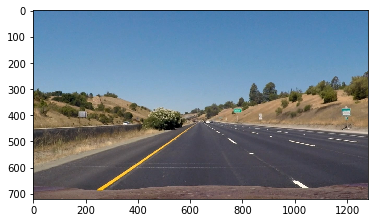

In [4]:
# image = mpimg.imread('../img/signs_vehicles_xygrad.jpg')
image = mpimg.imread('./test_images/straight_lines1.jpg')
# image = mpimg.imread('./test_images/test3.jpg')
# image = mpimg.imread('./test_images/test6.jpg')
plt.imshow(image)

In [5]:
# calibrate

cal_mages = glob.glob('./camera_cal/calibration*.jpg')
objpoints, imgpoints = calibration.calibrate(images=cal_mages)
pickle.dump([objpoints, imgpoints], open('calibration.pkl', 'wb'))

In [6]:
def draw(warped, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    return newwarp


In [7]:
def find_histogram_peaks(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base


In [8]:
def fit_sliding_window_polynomial(binary_warped, leftx_base, rightx_base, nwindows = 9, plot=False):
    """
    # Assuming you have created a warped binary image called "binary_warped"
    
    nwindows : Choose the number of sliding windows
    """
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot:
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    lr_xy_tuple = [(leftx, lefty), (rightx, righty)]
    return left_fit, right_fit, lr_xy_tuple

In [9]:
def find_line_pixels(binary_warped, left_fit, right_fit):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    lr_xy_tuple = [(leftx, lefty), (rightx, righty)]
    return left_fit, right_fit, lr_xy_tuple
    
   
def plot_():
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, .01, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [10]:
# Calculate the lane line curvature
def get_curvature(poly, mask):
    yscale = 30 / 720. # Real world metres per y pixel
    xscale = 3.7 / 700. # Real world metres per x pixel
    
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    fitx = poly[0] * ploty ** 2 + poly[1] * ploty + poly[2]
    
    # Fit new polynomial
    fit_cr = np.polyfit(ploty * yscale, fitx * xscale, 2)
    
    # Calculate curve radius
    curverad = ((1 + (2 * fit_cr[0] * np.max(ploty) * yscale + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    return curverad

In [11]:


# Plot the polygons on the image
def plot_poly_orig(fitl, fitr, orig):
    # Draw lines from polynomials
    ploty = np.linspace(0, orig.shape[0]-1, orig.shape[0])
    fitl = fitl[0]*ploty**2 + fitl[1]*ploty + fitl[2]
    fitr = fitr[0]*ploty**2 + fitr[1]*ploty + fitr[2]
    
    pts_left = np.array([np.transpose(np.vstack([fitl, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitr, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an overlay from the lane lines
    overlay = np.zeros_like(orig).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    overlay = transform.unwarp(overlay)
    
    # Add the overlay to the original unwarped image
    result = cv2.addWeighted(orig, 1, overlay, 0.3, 0)
    return result



In [12]:
# Find the offset of the car and the base of the lane lines
def find_offset(l_poly, r_poly):
    lane_width = 3.7  # metres
    h = 720  # height of image (index of image bottom)
    w = 1280 # width of image
    
    # Find the bottom pixel of the lane lines
    l_px = l_poly[0] * h ** 2 + l_poly[1] * h + l_poly[2]
    r_px = r_poly[0] * h ** 2 + r_poly[1] * h + r_poly[2]
    
    # Find the number of pixels per real metre
    scale = lane_width / np.abs(l_px - r_px)
    
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (w/2 - midpoint) * scale
    return offset

In [13]:
last_rad = None
last_l_poly = None
last_r_poly = None

def process_image(image):
    global PLOT
    global last_rad, last_l_poly, last_r_poly
    
    # Define weights for smoothing
    rad_alpha = 0.05
    poly_alpha = 0.2
    
    orig = image.copy()
    
    
    objpoints, imgpoints = pickle.load( open('calibration.pkl', 'rb'))
    
    # undistort
    undistorted = calibration.cal_undistort(image, objpoints, imgpoints)
    if PLOT:
        plotting.plot_side_by_side(image, undistorted, label1='Original Image', label2='Undistorted')
    
    # apply thresholds
    thresh_img = thresholds.apply_gradient_thresholds(image, ksize=5, sobel_thresh=(50,250))
    if PLOT:
        plotting.plot_side_by_side(undistorted, thresh_img, label1='Undistorted', label2='Thresholded')
        
    # perspective transform
    warped, Minv = perspective.get_perspective_transform(thresh_img)
    if PLOT:
        plotting.plot_side_by_side(undistorted, warped, label1='Undistorted & thresholded', label2='Perspective transform')
        
        # plot histogram
        plotting.plot_hist(warped)
        #histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
        #plotting.plot_side_by_side(warped, histogram, label1='Perspective transform', label2='Histogram')
        
        
    # find base peaks using histogram
    left_peak, right_peak = find_histogram_peaks(warped)
        
    

    # Update polynomials using weighted average with last frame
    if last_l_poly is None:
        # find lanes
        left_fit, right_fit, pixel_pos = fit_sliding_window_polynomial(warped, left_peak, right_peak)

        # If first frame, initialise buffer
        last_l_poly = left_fit
        last_r_poly = right_fit
    else:
        try:
            # Otherwise, update buffer
            left_fit, right_fit, pixel_pos = find_line_pixels(warped, last_l_poly, last_r_poly)
        except:
            return image
            #left_fit = (1 - poly_alpha) * last_l_poly + poly_alpha * left_fit
            #right_fit = (1 - poly_alpha) * last_r_poly + poly_alpha * right_fit
        last_l_poly = left_fit
        last_r_poly = right_fit
        
        
    #     # Define y-value where we want radius of curvature
    #     # I'll choose the maximum y-value, corresponding to the bottom of the image

    y_eval = np.max(warped.shape[1])
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    ###print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720. # meters per pixel in y dimension
    xm_per_pix = 3.7/700. # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fit_cr = np.polyfit(pixel_pos[0][1]*ym_per_pix, pixel_pos[0][0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(pixel_pos[1][1]*ym_per_pix, pixel_pos[1][0]*xm_per_pix, 2)

    # Calculate the new radii of curvature
    l_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    r_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
        
    # ======
    # Calculate the lane curvature radius
    #     l_rad = get_curvature(left_fit, warped)
    #     r_rad = get_curvature(right_fit, warped)

    # Get mean of curvatures
    rad = np.mean([l_rad, r_rad])

    # Update curvature using weighted average with last frame
    if last_rad is None:
        last_rad = rad
    else:
        last_rad = (1 - rad_alpha) * last_rad + rad_alpha * rad

    # Create image
    #final = plot_poly_orig(left_fit, right_fit, orig)

    
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    #assert left_fitx.all() == left_fitx_.all()

    newwarp = draw(warped, ploty, left_fitx, right_fitx, Minv)
   
    # Combine the result with the original image
    final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
     # Write radius on image
    cv2.putText(final, 'Lane Radius: {}m'.format(int(last_rad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)

    # Write lane offset on image
    offset = find_offset(left_fit, right_fit)
    cv2.putText(final, 'Lane Offset: {}m'.format(round(offset, 4)), (10, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    if PLOT:
        plt.imshow(final)
    return final

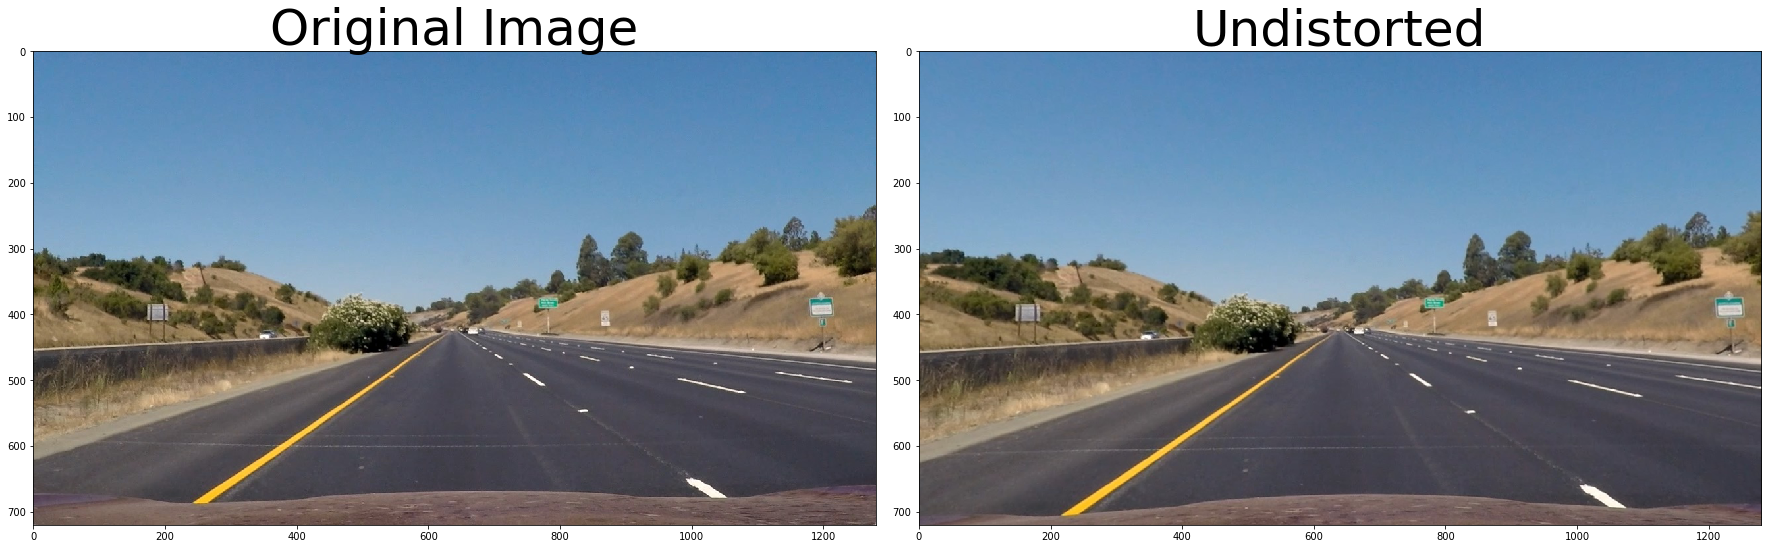

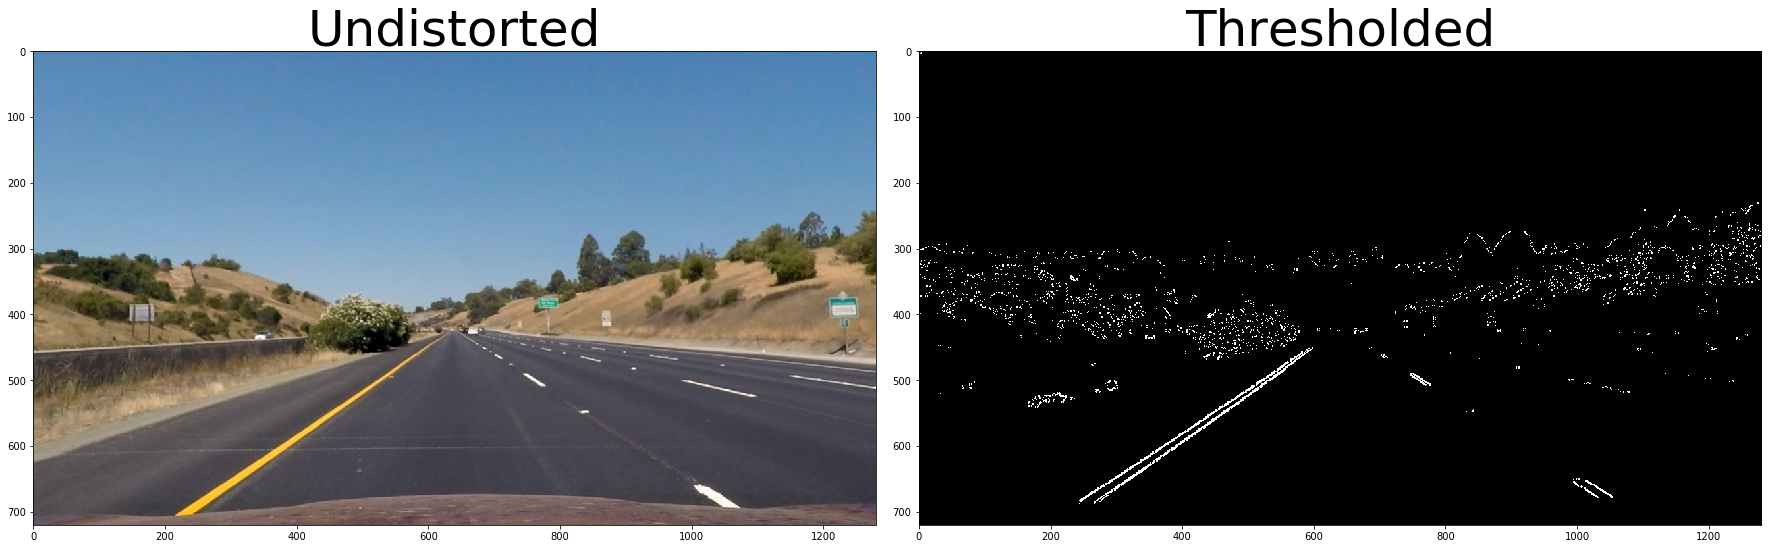

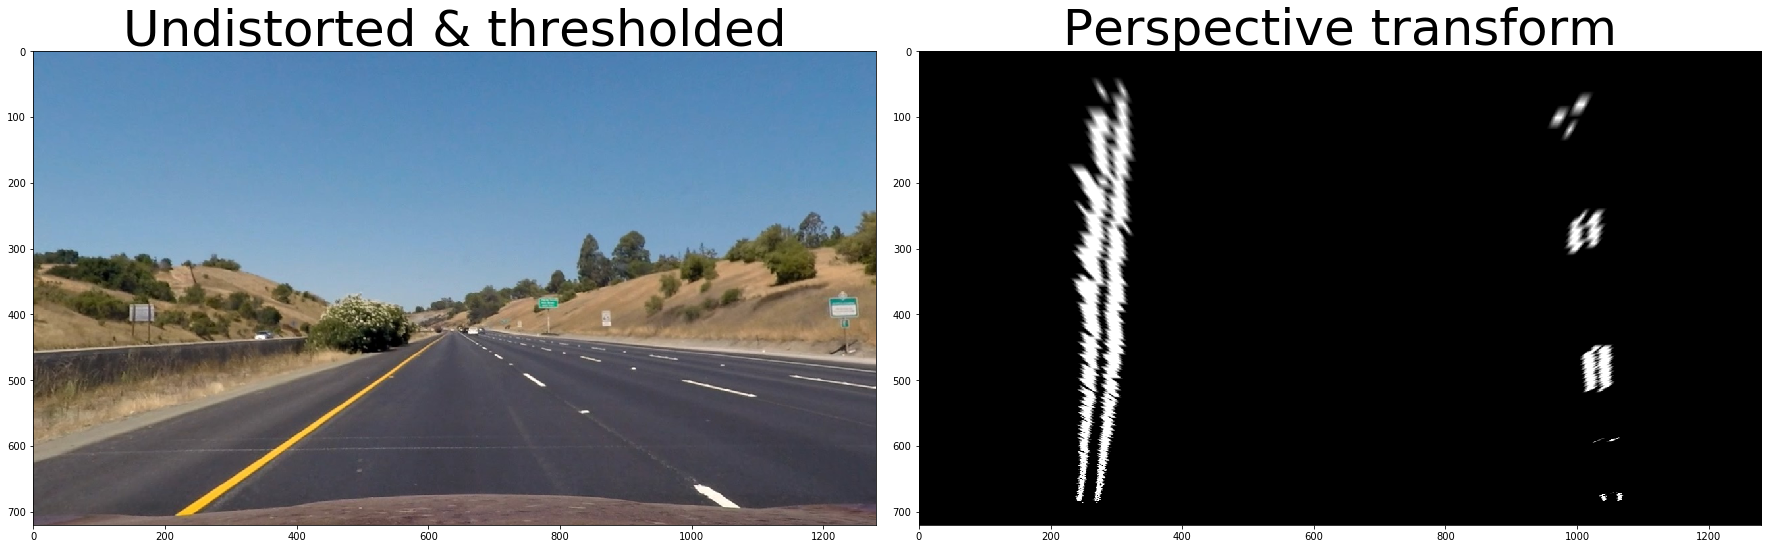

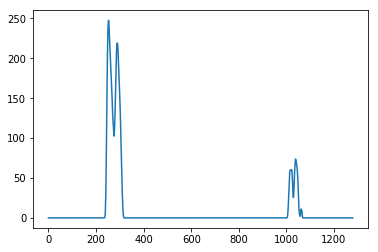

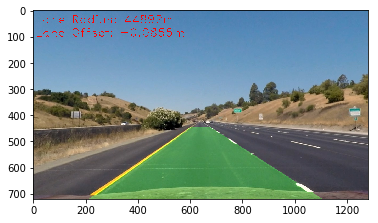

In [57]:
PLOT = True
result = process_image(image)

In [49]:
from moviepy.editor import VideoFileClip

# reset_globals()
# reset globals

def fit_late_lines(input_video, output_video):
    
    global PLOT
    global last_rad, last_l_poly, last_r_poly
    PLOT = False
    last_rad = None
    last_l_poly = None
    last_r_poly = None

    clip = VideoFileClip(input_video)
    procesed_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!

    %time procesed_clip.write_videofile(output_video, audio=False)

In [51]:
fit_late_lines('project_video.mp4', 'output/out_project_video.mp4')

[MoviePy] >>>> Building video output/out_project_video.mp4
[MoviePy] Writing video output/out_project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<17:57,  1.17it/s]




  0%|          | 2/1261 [00:01<18:02,  1.16it/s]


  0%|          | 3/1261 [00:02<17:52,  1.17it/s]


  0%|          | 4/1261 [00:03<17:50,  1.17it/s]


  0%|          | 5/1261 [00:04<17:42,  1.18it/s]


  0%|          | 6/1261 [00:05<17:47,  1.18it/s]


  1%|          | 7/1261 [00:06<18:08,  1.15it/s]


  1%|          | 8/1261 [00:07<19:00,  1.10it/s]


  1%|          | 9/1261 [00:08<19:40,  1.06it/s]


  1%|          | 10/1261 [00:09<20:06,  1.04it/s]


  1%|          | 11/1261 [00:10<22:18,  1.07s/it]


  1%|          | 12/1261 [00:11<23:48,  1.14s/it]


  1%|          | 13/1261 [00:13<27:50,  1.34s/it]


  1%|          | 14/1261 [00:16<38:24,  1.85s/it]


  1%|          | 15/1261 [00:20<53:51,  2.59s/it]


  1%|▏         | 16/1261 [00:22<50:34,  2.44s/it]


  1%|▏         | 17/1261 [00:24<48:10,  2.32s/it]


  1%|▏         | 18/1261 [00:27<46:26,  2.24s/it]


  2%|▏         | 19/1261 

[MoviePy] Done.
[MoviePy] >>>> Video ready: output/out_project_video.mp4 

CPU times: user 33min 29s, sys: 4.52 s, total: 33min 33s
Wall time: 31min 35s


In [52]:
fit_late_lines('challenge_video.mp4', 'output/out_challenge_video.mp4')

[MoviePy] >>>> Building video output/out_challenge_video.mp4
[MoviePy] Writing video output/out_challenge_video.mp4


100%|██████████| 485/485 [12:13<00:00,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/out_challenge_video.mp4 

CPU times: user 12min 57s, sys: 2.06 s, total: 12min 59s
Wall time: 12min 14s


In [53]:
fit_late_lines('harder_challenge_video.mp4', 'output/out_harder_challenge_video.mp4')

[MoviePy] >>>> Building video output/out_harder_challenge_video.mp4
[MoviePy] Writing video output/out_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [29:52<00:01,  1.50s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/out_harder_challenge_video.mp4 

CPU times: user 31min 39s, sys: 3.89 s, total: 31min 43s
Wall time: 29min 53s
